In [72]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold


import numpy as np
import pandas as pd
import sys

from polyssifier import poly

import logging 

import scipy.sparse as sp
import scipy.io
from scipy.stats import zscore
from scipy.signal import detrend

from scipy.sparse.linalg import eigs
from gunfolds.utils import graphkit as gk
from gunfolds.conversions import graph2adj

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer

In [57]:

df = sm.datasets.get_rdataset('flights', 'nycflights13').data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

In [58]:

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [59]:

df['arr_hour'] = df.arr_time.apply(lambda x: int(np.floor(x/100)))
df['arr_minute'] = df.arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_arr_hour'] = df.sched_arr_time.apply(lambda x: int(np.floor(x/100)))
df['sched_arr_minute'] = df.sched_arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_dep_hour'] = df.sched_dep_time.apply(lambda x: int(np.floor(x/100)))
df['sched_dep_minute'] = df.sched_dep_time.apply(lambda x: int(x - np.floor(x/100)*100))
df.rename(columns={'hour': 'dep_hour', 
                   'minute': 'dep_minute'}, inplace=True)
                   

In [60]:

group = df.tailnum.tolist()


In [61]:

target = 'arr_delay'
y = df[target]
X = df.drop(columns=[target, 'flight', 'time_hour', 'year', 'dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'dep_delay'])


In [62]:

gkf = GroupKFold(n_splits=10)
for train_index, test_index in gkf.split(X, groups=group):
    print("Train:", train_index, "Test:", test_index)
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    

Train: [     0      1      2 ... 327343 327344 327345] Test: [    16     28     38 ... 327322 327329 327342]
Train: [     0      2      3 ... 327342 327343 327345] Test: [     1      8     10 ... 327320 327335 327344]
Train: [     0      1      2 ... 327343 327344 327345] Test: [     9     14     15 ... 327289 327309 327341]
Train: [     0      1      2 ... 327343 327344 327345] Test: [     5     23     24 ... 327324 327332 327336]
Train: [     0      1      2 ... 327342 327343 327344] Test: [     6     12     29 ... 327331 327334 327345]
Train: [     0      1      2 ... 327343 327344 327345] Test: [    13     17     52 ... 327317 327325 327333]
Train: [     0      1      3 ... 327343 327344 327345] Test: [     2      7     26 ... 327287 327305 327306]
Train: [     0      1      2 ... 327343 327344 327345] Test: [    21     22     41 ... 327301 327316 327330]
Train: [     0      1      2 ... 327343 327344 327345] Test: [     3      4     11 ... 327337 327338 327339]
Train: [     1     

In [63]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [200]:

def check_matrix_powers(W, A, powers, threshold):
    for n in powers:
        W_n = np.linalg.matrix_power(W, n)
        non_zero_indices = np.nonzero(W_n)
        if (np.abs(W_n[non_zero_indices]) < threshold).any():
            return False
    return True


def create_stable_weighted_matrix(
    A,
    threshold=0.1,
    powers=[1, 2, 3, 4],
    max_attempts=1000,
    damping_factor=0.99,
    random_state=None,
):
    np.random.seed(
        random_state
    )  # Set random seed for reproducibility if provided
    attempts = 0

    while attempts < max_attempts:
        # Generate a random matrix with the same sparsity pattern as A
        random_weights = np.random.randn(*A.shape)
        weighted_matrix = A * random_weights

        # Convert to sparse format for efficient eigenvalue computation
        weighted_sparse = sp.csr_matrix(weighted_matrix)

        # Compute the largest eigenvalue in magnitude
        eigenvalues, _ = eigs(weighted_sparse, k=1, which="LM")
        max_eigenvalue = np.abs(eigenvalues[0])

        # Scale the matrix so that the spectral radius is slightly less than 1
        if max_eigenvalue > 0:
            weighted_matrix *= damping_factor / max_eigenvalue
            # Check if the powers of the matrix preserve the threshold for non-zero entries of A
            if check_matrix_powers(weighted_matrix, A, powers, threshold):
                return weighted_matrix

        attempts += 1

    raise ValueError(
        f"Unable to create a matrix satisfying the condition after {max_attempts} attempts."
    )


def drawsamplesLG(A, nstd, samples):
    n = A.shape[0]
    data = np.zeros([n, samples])
    data[:, 0] = nstd * np.random.randn(A.shape[0])
    for i in range(1, samples):
        data[:, i] = A @ data[:, i - 1] + nstd * np.random.randn(A.shape[0])
    return data


def genData(A, rate=2, burnin=100, ssize=5000, nstd=0.1):
    Agt = A.copy()
    data = drawsamplesLG(Agt, samples=burnin + (ssize * rate), nstd=nstd)
    data = data[:, burnin:]
    return data[:, ::rate]


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


#Step 0: Iterate through values for nstd, burnin, noise_svar
nstd = 1.0
burn = 100
threshold = 0.0001

In [201]:
NOISE_SIZE = 2961*2
NUM_SUBS = 10
subjects = ['20150210', '20150417', '20150428', '20151110', '20151127', 
            '20150410', '20150421', '20151030', '20151117', '20151204']

num_graphs = 1
num_noise = 1
n_folds = 3
n_threads= 12

graph_ix = 1002
graph_dir = '/data/users2/jwardell1/nshor_docker/examples/oulu-project/OULU/g4.pkl'
g = np.load(graph_dir, allow_pickle=True)
A = graph2adj(g)
u_rate = 1
logging.info(f'\t\t\t\tGraph Number {graph_ix} of {num_graphs}')

SNR = 1
scalar = 10**(SNR/-2)


2024-05-06 20:44:04,458 - INFO - 				Graph Number 1002 of 1


In [202]:
num_converged = 0
converged_subjects = []
noises = dict()
while num_converged < NUM_SUBS:
    for subject in subjects:
        if subject in converged_subjects:
            continue

        try:
            W = create_stable_weighted_matrix(A, threshold=threshold, powers=[2])
            var_noise = genData(W, rate=u_rate, burnin=burn, ssize=NOISE_SIZE, nstd=nstd)
            var_noise = zscore(var_noise, axis=1)
            noises[subject] = var_noise*scalar
            num_converged += 1
            converged_subjects.append(subject)

        except Exception as e:
            print(e)
            logging.info(f'num converged: {num_converged}')
            


2024-05-06 20:44:20,763 - INFO - num converged: 0


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:21,148 - INFO - num converged: 2


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:21,487 - INFO - num converged: 3


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:21,842 - INFO - num converged: 4


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:22,194 - INFO - num converged: 5


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:22,693 - INFO - num converged: 8


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-06 20:44:22,995 - INFO - num converged: 9


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


In [203]:
len(noises)

10

In [204]:
all_data = []

with open('/data/users2/jwardell1/undersampling-project/OULU/txt-files/allsubs_TCs.txt', 'r') as tc_data:
    lines = tc_data.readlines()

for i in range(0, len(lines), 2):
    subject = subjects[i//2]
    logging.info(f'loading TC for subject {subject}')
    filepath_sr1 = lines[i].strip()
    filepath_sr2 = lines[i+1].strip()
    try:
        sr1 = scipy.io.loadmat(filepath_sr1)['TCMax']
        sr2 = scipy.io.loadmat(filepath_sr2)['TCMax']
    
    except:
        continue

    if sr1.shape[0] != 53:
        sr1 = sr1.T

    if sr2.shape[0] != 53:
        sr2 = sr2.T
    
    if sr1.shape[1] < sr2.shape[1]:
        tr100_tc = sr2
        tr2150_tc = sr1
    else:
        tr100_tc = sr1
        tr2150_tc = sr2

    logging.info(f'subject {subject} tr100_tc.shape - {tr100_tc.shape}')
    logging.info(f'subject {subject} tr2150_tc.shape - {tr2150_tc.shape}')

    tr100_tc_zs = zscore(tr100_tc, axis=1)
    tr2150_tc_zs = zscore(tr2150_tc, axis=1)

    tr100_tc_zs_dt = detrend(tr100_tc_zs, axis=1)
    tr2150_tc_zs_dt = detrend(tr2150_tc_zs, axis=1)

    noise_tr100 = noises[subject][:,::2]
    noise_tr2150 = noises[subject][:,::33]

    tr100_tc_zs_dt_noise = tr100_tc_zs_dt+noise_tr100
    tr2150_tc_zs_dt_noise = tr2150_tc_zs_dt+noise_tr2150

    all_data.append({'Subject_ID'             : str(subject), 
                    'VAR_Noise'               : noises[subject], 
                    'TR100_Noise'             : noise_tr100, 
                    'TR2150_Noise'            : noise_tr2150, 
                    'TR100_Timecourse'        : tr100_tc_zs_dt, 
                    'TR2150_Timecourse'       : tr2150_tc_zs_dt, 
                    'TR100_Timecourse_Noise'  : tr100_tc_zs_dt_noise, 
                    'TR2150_Timecourse_Noise' : tr2150_tc_zs_dt_noise})
    
data_df = pd.DataFrame(all_data)

2024-05-06 20:44:40,441 - INFO - loading TC for subject 20150210
2024-05-06 20:44:40,454 - INFO - subject 20150210 tr100_tc.shape - (53, 2961)
2024-05-06 20:44:40,455 - INFO - subject 20150210 tr2150_tc.shape - (53, 180)
2024-05-06 20:44:40,539 - INFO - loading TC for subject 20150417
2024-05-06 20:44:40,577 - INFO - subject 20150417 tr100_tc.shape - (53, 2961)
2024-05-06 20:44:40,577 - INFO - subject 20150417 tr2150_tc.shape - (53, 180)
2024-05-06 20:44:40,631 - INFO - loading TC for subject 20150428
2024-05-06 20:44:40,661 - INFO - subject 20150428 tr100_tc.shape - (53, 2961)
2024-05-06 20:44:40,662 - INFO - subject 20150428 tr2150_tc.shape - (53, 180)
2024-05-06 20:44:40,707 - INFO - loading TC for subject 20151110
2024-05-06 20:44:40,732 - INFO - subject 20151110 tr100_tc.shape - (53, 2961)
2024-05-06 20:44:40,732 - INFO - subject 20151110 tr2150_tc.shape - (53, 180)
2024-05-06 20:44:40,788 - INFO - loading TC for subject 20151127
2024-05-06 20:44:40,825 - INFO - subject 20151127 t

In [205]:
data_df

,Subject_ID,VAR_Noise,TR100_Noise,TR2150_Noise,TR100_Timecourse,TR2150_Timecourse,TR100_Timecourse_Noise,TR2150_Timecourse_Noise
0,20150210,"[[-0.20558868763082727, -0.2722194562363934, -...","[[-0.20558868763082727, -0.25296201588847994, ...","[[-0.20558868763082727, 0.12590681769916331, 0...","[[-0.04384497970934843, -1.1089141040646808, -...","[[0.6886887100527853, -0.49795380956891466, -0...","[[-0.2494336673401757, -1.3618761199531608, -0...","[[0.48310002242195804, -0.3720469918697513, -0..."
1,20150417,"[[0.33496035334505575, 0.04929764188381271, -0...","[[0.33496035334505575, -0.5877649502670702, -0...","[[0.33496035334505575, 0.0850085728716799, 0.1...","[[-0.16072029250058273, -0.8571620023770676, -...","[[-3.4277492842723736, -1.2679357539105018, 0....","[[0.17424006084447302, -1.444926952644138, -0....","[[-3.092788930927318, -1.182927181038822, 0.33..."
2,20150428,"[[-0.3336757777502661, -0.014850383580086607, ...","[[-0.3336757777502661, 0.0034649483872345476, ...","[[-0.3336757777502661, 0.1018179719577971, 0.5...","[[-0.2373189115113954, -0.9356178523703156, -0...","[[-6.277579290892411, -3.145414582661277, -1.8...","[[-0.5709946892616615, -0.932152903983081, -1....","[[-6.611255068642677, -3.04359661070348, -1.33..."
3,20151110,"[[0.05444424354959927, 0.01743622751113338, -0...","[[0.05444424354959927, -0.04021440282121913, -...","[[0.05444424354959927, -0.33285288200843455, 0...","[[0.04160904884036762, -1.0327117238148629, -1...","[[-1.7756207977992475, -0.5414674717187069, 0....","[[0.09605329238996689, -1.072926126636082, -1....","[[-1.7211765542496482, -0.8743203537271415, 0...."
4,20151127,"[[-0.4132284594607818, 0.04021687641791068, -0...","[[-0.4132284594607818, -0.37008726438812106, -...","[[-0.4132284594607818, 0.2243896806214354, -0....","[[0.4715334566403784, 0.8085277405442561, 0.57...","[[-0.546821608407083, 0.8562373936238571, 1.65...","[[0.058304997179596585, 0.4384404761561351, 0....","[[-0.9600500678678648, 1.0806270742452926, 1.4..."
5,20150410,"[[0.140136753215449, 0.6725854871267704, 0.240...","[[0.140136753215449, 0.24063998357664557, 0.10...","[[0.140136753215449, -0.14786769322943066, -0....","[[-0.6993045949882399, -0.7668812618463146, -0...","[[1.8769652714231873, 1.5203291646052297, 1.27...","[[-0.559167841772791, -0.526241278269669, -0.7...","[[2.0171020246386364, 1.372461471375799, 1.276..."
6,20150421,"[[0.47954965894067186, 0.056198246903892204, -...","[[0.47954965894067186, -0.394686062394286, -0....","[[0.47954965894067186, -0.13479694830866676, -...","[[-0.22469426804641845, -0.27654691337810755, ...","[[-0.74056219245013, 0.4103006363113777, 0.534...","[[0.2548553908942534, -0.6712329757723936, -0....","[[-0.26101253350945813, 0.27550368800271097, 0..."
7,20151030,"[[0.1980444516042698, 0.00843305658739318, -0....","[[0.1980444516042698, -0.11618353878650836, -0...","[[0.1980444516042698, 0.09950083771015832, 0.0...","[[0.44607973266800116, 0.4241701201936101, -0....","[[0.2628610467057933, 0.8372100798045181, -0.5...","[[0.6441241842722709, 0.3079865814071018, -0.3...","[[0.4609054983100631, 0.9367109175146764, -0.4..."
8,20151117,"[[-0.26824666566664873, -0.41380226643433304, ...","[[-0.26824666566664873, -0.29540448107436784, ...","[[-0.26824666566664873, 0.12378205905374423, -...","[[-0.28618495145219935, -0.13063913448791498, ...","[[-1.916928108245413, 0.24752955049021075, -1....","[[-0.5544316171188481, -0.4260436155622828, 0....","[[-2.185174773912062, 0.371311609543955, -1.28..."
9,20151204,"[[-0.24304019517521444, -0.2668465809391584, 0...","[[-0.24304019517521444, 0.24753448107533518, -...","[[-0.24304019517521444, 0.12690004559205195, 0...","[[0.07960842193259587, 0.42248155101438867, 0....","[[-0.24946115167442184, -0.8214981758873072, 0...","[[-0.16343177324261857, 0.6700160320897238, -0...","[[-0.4925013468496363, -0.6945981302952553, 1...."


In [174]:


subject = subjects[1]
sub_row = data_df[data_df['Subject_ID']  == subject]
tr100 = sub_row['TR100_Timecourse']
tr100.iloc[0]


array([[-0.16072029, -0.857162  , -0.88618188, ..., -0.24475312,
        -0.0390325 ,  2.77158204],
       [-0.27577565,  0.78793228, -0.40742249, ...,  1.06567845,
         1.16948401, -1.09990769],
       [-0.18637006,  0.10227699, -0.33758139, ..., -0.31839054,
        -0.04208736, -1.18216846],
       ...,
       [-1.69537915, -1.60145677, -1.36767595, ..., -3.08402763,
        -3.01850292, -3.76039927],
       [-0.5619479 ,  0.09993209, -0.60095344, ...,  1.11671087,
         1.32260834,  0.19622501],
       [-0.35776988, -0.17315649, -0.34432158, ...,  0.75819931,
         0.733682  , -0.1983396 ]])

In [206]:
tr100_data = []
tr2150_data = []
add_data = []
concat_data = []

for subject in subjects:
    sub_row = data_df[data_df['Subject_ID']  == subject]
    logging.info(f'subject {subject}')

    tr100 = sub_row['TR100_Timecourse'].iloc[0]
    tr100_noise = sub_row['TR100_Timecourse_Noise'].iloc[0]
    
    tr2150 = sub_row['TR2150_Timecourse'].iloc[0]
    tr100_noise = sub_row['TR2150_Timecourse_Noise'].iloc[0]

    n_regions, n_tp_tr100 = tr100.shape
    _, n_tp_tr2150 = tr2150.shape

    tr2150_window_size = 100
    tr2150_stride = 1
    n_sections = 80
    tr2150_start_ix = 0
    tr2150_end_ix = tr2150_window_size
    
    tr100_window_size = int((n_tp_tr100 / n_tp_tr2150) * tr2150_window_size)
    tr100_stride = n_tp_tr100 // n_tp_tr2150
    tr100_start_ix = 0
    tr100_end_ix = tr100_window_size


    for j in range(n_sections):
        window_ix = i * n_sections * 2 + j * 2
        
        tr100_section = tr100[:, tr100_start_ix:tr100_end_ix]
        tr100_section_noise = tr100_noise[:, tr100_start_ix:tr100_end_ix]

        tr2150_section = tr2150[:, tr2150_start_ix:tr2150_end_ix]
        tr2150_section_noise = tr100_noise[:, tr2150_start_ix:tr2150_end_ix]






        tr100_fnc_triu = np.corrcoef(tr100_section)[np.triu_indices(n_regions)]
        tr100_noise_fnc_triu = np.corrcoef(tr100_section_noise)[np.triu_indices(n_regions)]

        tr2150_fnc_triu = np.corrcoef(tr2150_section)[np.triu_indices(n_regions)]
        tr2150_noise_fnc_triu = np.corrcoef(tr2150_section_noise)[np.triu_indices(n_regions)]

        concat_tr100_tr2150 = np.concatenate((tr100_fnc_triu , tr2150_fnc_triu))
        concat_tr100_tr2150_noise = np.concatenate((tr100_noise_fnc_triu , tr2150_noise_fnc_triu))

        add_tr100_tr2150 = tr100_fnc_triu + tr2150_fnc_triu
        add_tr100_tr2150_noise = tr100_noise_fnc_triu + tr2150_noise_fnc_triu


        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_fnc_triu, 
                           'target'           : '0'})
        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_noise_fnc_triu, 
                           'target'           : '1'})
        
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_fnc_triu, 
                            'target'          : '0'})
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_noise_fnc_triu, 
                            'target'          : '1'})
        
        concat_data.append({'subject'         : subject, 
                            'Concat_Window'   : concat_tr100_tr2150,
                           'target'          : '0'})
        concat_data.append({'subject'         : subject, 
                           'Concat_Window'   : concat_tr100_tr2150_noise,
                           'target'          : '1'})
        
        add_data.append({'subject'            : subject,
                         'Add_Window'         : add_tr100_tr2150,
                         'target'             : '0'})
        add_data.append({'subject'            : subject,
                         'Add_Window'         : add_tr100_tr2150,
                         'target'             : '1'})



tr100_df = pd.DataFrame(tr100_data)
tr2150_df = pd.DataFrame(tr2150_data)
concat_df = pd.DataFrame(concat_data)
add_df = pd.DataFrame(add_data)



2024-05-06 20:44:57,011 - INFO - subject 20150210
2024-05-06 20:44:57,113 - INFO - subject 20150417
2024-05-06 20:44:57,203 - INFO - subject 20150428
2024-05-06 20:44:57,293 - INFO - subject 20151110
2024-05-06 20:44:57,382 - INFO - subject 20151127
2024-05-06 20:44:57,474 - INFO - subject 20150410
2024-05-06 20:44:57,565 - INFO - subject 20150421
2024-05-06 20:44:57,666 - INFO - subject 20151030
2024-05-06 20:44:57,760 - INFO - subject 20151117
2024-05-06 20:44:57,861 - INFO - subject 20151204


In [227]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [238]:
group = tr100_df['subject']
y = tr100_df['target']
y = np.array([str(entry) for entry in y])
X = tr100_df['TR100ms_Window']
X = np.array([np.array(entry) for entry in X_tr100])
y.shape

(1600,)

In [245]:
mylist = [[1,2,3,4,2,5],[-1,-9,-8,-7,-6,-5]]
mylist[:,-1]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
res1 = []

gkf = GroupKFold(n_splits=10)
fold_ix = 0
for train_index, test_index in gkf.split(X, groups=group):
    print("Fold:", fold_ix, "Train:", train_index, "\nTest:", test_index)
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    print('\n')
    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    res1.append({'Fold'      : fold_ix,
                'pred_proba' : y_pred_proba,
                'y_pred'     : y_pred,
                'target'     : target,
                'auc'        : auc})
    fold_ix += 1
   
res1_df = pd.DataFrame(res1)

In [253]:
scalar

0.31622776601683794

In [ ]:

gkf = GroupKFold(n_splits=10)
for train_index, test_index in gkf.split(X, groups=group):
    print("Train:", train_index, "Test:", test_index)
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    

2024-05-06 20:47:32,897 - INFO - Detected 2 classes in label
2024-05-06 20:47:32,898 - INFO - Building classifiers ...
2024-05-06 20:47:32,904 - INFO - Initialization, done.
2024-05-06 20:47:32,905 - INFO - Detected 10 unique groups
2024-05-06 20:47:33,571 - INFO - Training Multilayer Perceptron 1
2024-05-06 20:47:33,652 - INFO - Training Multilayer Perceptron 0
2024-05-06 20:47:33,700 - INFO - Training Multilayer Perceptron 2
2024-05-06 20:47:33,880 - INFO - Training SVM 0
2024-05-06 20:47:33,988 - INFO - Training SVM 1
2024-05-06 20:47:34,176 - INFO - Training Logistic Regression 1
2024-05-06 20:47:34,163 - INFO - Training Logistic Regression 0
2024-05-06 20:47:34,195 - INFO - Training SVM 2
2024-05-06 20:47:34,248 - INFO - Training Naive Bayes 0
2024-05-06 20:47:34,239 - INFO - Training Logistic Regression 2
2024-05-06 20:47:34,365 - INFO - Training Naive Bayes 2
2024-05-06 20:47:34,404 - INFO - Training Naive Bayes 1
2024-05-06 20:47:35,813 - INFO - Naive Bayes                0: Tr

                             mean           std  min  max
Multilayer Perceptron train   1.0  0.000000e+00  1.0  1.0
                      test    1.0  0.000000e+00  1.0  1.0
SVM                   train   1.0  0.000000e+00  1.0  1.0
                      test    1.0  0.000000e+00  1.0  1.0
Logistic Regression   train   1.0  1.110223e-16  1.0  1.0
                      test    1.0  7.850462e-17  1.0  1.0
Naive Bayes           train   1.0  0.000000e+00  1.0  1.0
                      test    1.0  0.000000e+00  1.0  1.0
Voting                train   1.0  0.000000e+00  1.0  1.0
                      test    1.0  0.000000e+00  1.0  1.0


NameError: name 'noise_ix' is not defined

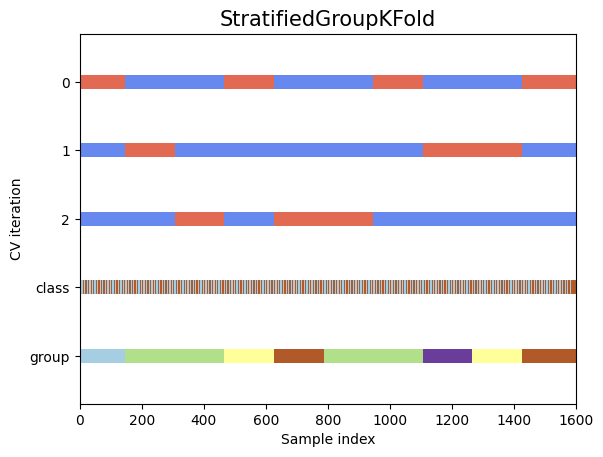

In [210]:
res1 = []

report1 = poly(data=X_tr100, label=y_tr100, groups=group_tr100, n_folds=3, scale=True, concurrency=12, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')



res1.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'scalar': scalar,
                            'classifier': classifier,
                            'test_scores': report1.scores[classifier, 'test'], 
                            'target': report1.target, 
                            'predictions': np.array(report1.predictions[classifier]).astype(int),
                            'test_proba': report1.test_proba[classifier]})

res1_df = pd.df(res1)